In [ ]:
!pip install xgboost


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, ParameterSampler
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

import xgboost as xgb
from scipy.stats import uniform, randint

from tqdm.auto import tqdm  # progress bar

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
synthtic_data_path = '/content/drive/My Drive/Life expectancy - Final Project/Data/synthetic_life_expectancy_data.csv'
df = pd.read_csv(synthtic_data_path)
df.drop("Country", axis=1, inplace=True)
df['Sex'] = df['Sex'].map({'Male': 0, 'Female': 1})
df.head()

,Sex,Life_expectancy,BMI,Alcohol,Schooling,Smoking
0,0,48.7,42.9,6.07,19.5,0
1,1,53.2,10.0,3.28,17.5,0
2,1,69.4,15.6,8.62,11.0,0
3,0,58.6,52.6,0.00,11.4,0
4,0,64.8,10.3,4.70,16.4,0


Hyperparam search:   0%|          | 0/50 [00:00<?, ?trial/s]


Best CV RMSE: 10.050
Best params:
  xgb__colsample_bytree: 0.9633063543866615
  xgb__learning_rate: 0.08186856720009172
  xgb__max_depth: 4
  xgb__n_estimators: 152
  xgb__reg_alpha: 0.489452760277563
  xgb__reg_lambda: 0.9856504541106007
  xgb__subsample: 0.6968221086046001

Test RMSE: 10.02
Test R²:   0.241


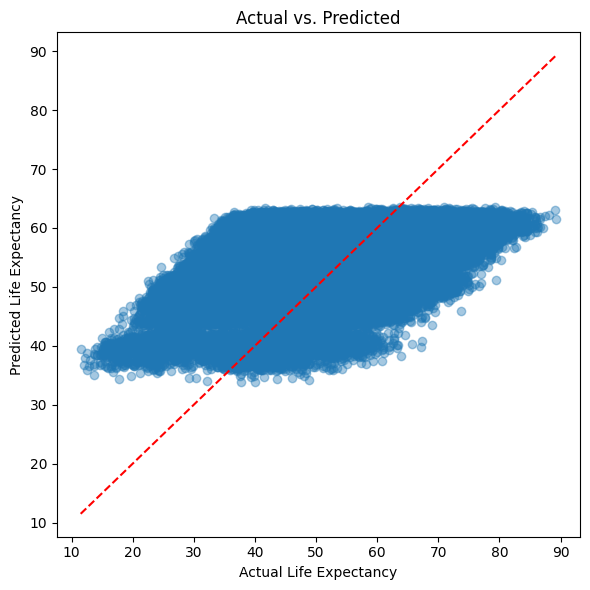

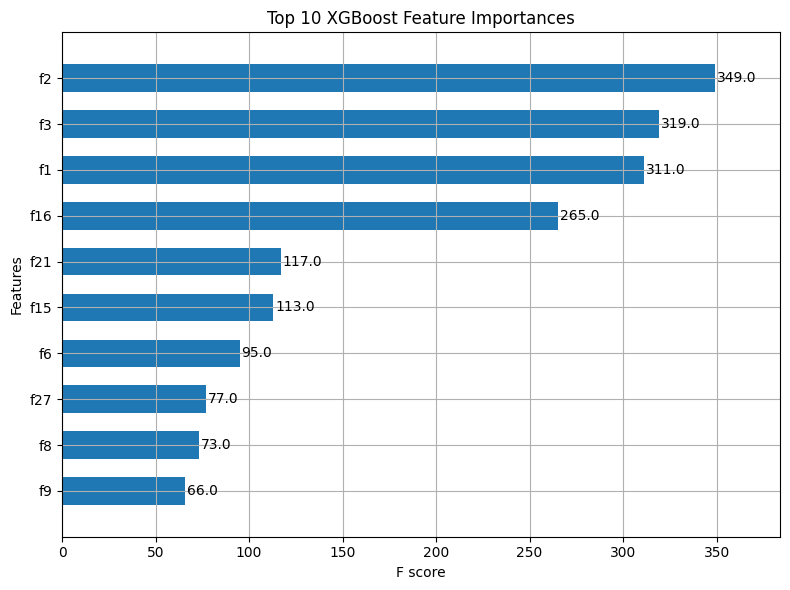

In [ ]:


# Optional interaction features
df['BMI_x_Smoke'] = df['BMI'] * df['Smoking']
df['Alc_x_Smoke'] = df['Alcohol'] * df['Smoking']

# =============================================================================
# 2) Split into X/y and train/test
# =============================================================================
TARGET = 'Life_expectancy'
X = df.drop(columns=[TARGET])
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# =============================================================================
# 3) Prepare Pipeline
# =============================================================================
pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scale', StandardScaler()),
    ('xgb', xgb.XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1
    ))
])

# =============================================================================
# 4) Define hyperparameter distributions
# =============================================================================
param_dist = {
    'xgb__n_estimators':     randint(100, 1000),
    'xgb__max_depth':        randint(3, 12),
    'xgb__learning_rate':    uniform(0.01, 0.3),
    'xgb__subsample':        uniform(0.6, 0.4),
    'xgb__colsample_bytree': uniform(0.6, 0.4),
    'xgb__reg_alpha':        uniform(0, 1),
    'xgb__reg_lambda':       uniform(0, 1),
}

# Pre-sample 50 random sets
param_list = list(ParameterSampler(param_dist, n_iter=50, random_state=42))

# =============================================================================
# 5) Manual random search with tqdm
# =============================================================================
best_score = float('inf')
best_params = None

# tqdm(total=50) will show [##########] 100% form
for params in tqdm(param_list, desc="Hyperparam search", unit="trial"):
    # set parameters
    pipeline.set_params(**params)
    # 5-fold CV, negative RMSE
    scores = cross_val_score(
        pipeline,
        X_train, y_train,
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )
    rmse = -scores.mean()
    # track best
    if rmse < best_score:
        best_score = rmse
        best_params = params

print(f"\nBest CV RMSE: {best_score:.3f}")
print("Best params:")
for k,v in best_params.items():
    print(f"  {k}: {v}")

# =============================================================================
# 6) Refit on full training set with best params
# =============================================================================
pipeline.set_params(**best_params)
pipeline.fit(X_train, y_train)

# =============================================================================
# 7) Evaluate on test set
# =============================================================================
y_pred = pipeline.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
r2_test   = r2_score(y_test, y_pred)
print(f"\nTest RMSE: {rmse_test:.2f}")
print(f"Test R²:   {r2_test:.3f}")

# =============================================================================
# 8) Plot Actual vs Predicted
# =============================================================================
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.4)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, 'r--')
plt.xlabel("Actual Life Expectancy")
plt.ylabel("Predicted Life Expectancy")
plt.title("Actual vs. Predicted")
plt.tight_layout()
plt.show()

# =============================================================================
# 9) Feature Importance
# =============================================================================
xgb_model = pipeline.named_steps['xgb']
fig, ax = plt.subplots(figsize=(8,6))
xgb.plot_importance(xgb_model, max_num_features=10, height=0.6, ax=ax)
plt.title("Top 10 XGBoost Feature Importances")
plt.tight_layout()
plt.show()

In [ ]:
import pickle
# Assuming your model is in the variable `model`
with open("xgb_model.pkl", "wb") as f:
    pickle.dump(pipeline, f)

In [ ]:
example_input = np.array([
    [0, 32, 10,16, 1,50]
])

prediction = pipeline.predict(example_input)

print(prediction)